<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/DAM_LoRA_DoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DAM (Depth Anything Model)
Paper: https://arxiv.org/pdf/2401.10891

#Customized DAM with LoRA

raw input (706, 884)
torch.Size([1, 1703, 384])
head predicted_depth: torch.Size([1, 32, 518, 644])
raw input (706, 884) inputs torch.Size([1, 3, 518, 644]) predicted_depth torch.Size([1, 518, 644])
Original model train on the scale of 0 to 30
prediction: min scale = 4.7774177 max scale= 17.73726


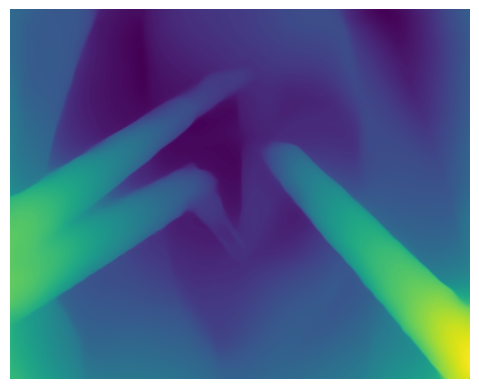

In [2]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn

from peft import TaskType
from peft import LoraModel, LoraConfig
from peft import LoraConfig, get_peft_model, PeftModel


class DepthAnythingDepthEstimationHead(nn.Module):

    def __init__(self, model_head):
        super().__init__()

        self.conv1 = model_head.conv1
        self.conv2 = model_head.conv2
        self.activation1 = nn.ReLU()
        self.conv3 = model_head.conv3
        self.activation2 = nn.ReLU()

    def forward(self, hidden_states, height, width):

        predicted_depth = self.conv1(hidden_states)
        predicted_depth = nn.functional.interpolate(
            predicted_depth,
            (int(height), int(width)),
            mode="bilinear",
            align_corners=True,
        )
        print('head predicted_depth:', predicted_depth.shape)
        predicted_depth = self.conv2(predicted_depth)
        predicted_depth = self.activation1(predicted_depth)
        predicted_depth = self.conv3(predicted_depth)
        predicted_depth = self.activation2(predicted_depth)
        predicted_depth = predicted_depth.squeeze(dim=1)  # shape (batch_size, height, width)

        return predicted_depth


class Customised_DAM(nn.Module):
    def __init__(self, lora_config=None):
        super(Customised_DAM, self).__init__()
        model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
        model = get_peft_model(model, lora_config)
        self.config = model.config
        self.backbone = model.backbone

        self.neck = model.neck
        model_head = model.head
        self.head = DepthAnythingDepthEstimationHead(model_head)
        model.post_init()


    def forward(self, pixel_values):

        outputs = self.backbone(
            pixel_values, output_hidden_states=None, output_attentions=None
        ) # pixel_values:[3, 256, 320] , output:4, [1, 397, 384]
        hidden_states = outputs.feature_maps
        print(hidden_states[0].shape)
        _, _, height, width = pixel_values.shape
        patch_size = self.config.patch_size
        patch_height = height // patch_size
        patch_width = width // patch_size

        # print('h,w, p, ph, pw', height, width, patch_size, patch_height, patch_width) #h,w, p, ph, pw 256 320 14 18 22
        hidden_states = self.neck(hidden_states, patch_height, patch_width)

        #[1, 64, 18, 22], [1, 64, 36, 44], [1, 64, 72, 88], [1, 64, 144, 176]
        # print('hidden_states2', len(hidden_states), hidden_states[0].shape, hidden_states[1].shape, hidden_states[2].shape, hidden_states[3].shape)
        predicted_depth = self.head(hidden_states[3], height, width)
        # outputs = {}
        # outputs[("disp", 0)] = self.head(hidden_states[3], height, width)
        # outputs[("disp", 1)] = self.head(hidden_states[3], height/2, width/2)
        # outputs[("disp", 2)] = self.head(hidden_states[3], height/4, width/4)
        # outputs[("disp", 3)] = self.head(hidden_states[3], height/8, width/8)
        # print(outputs[("disp", 0)].shape, outputs[("disp", 1)].shape,outputs[("disp", 2)].shape,outputs[("disp", 3)].shape,)
        # return outputs[("disp", 0)]
        return predicted_depth


# Configure LoRA
lora_config = LoraConfig(
    inference_mode=False,         # Set to True for inference-only
    r=8,                          # Rank of LoRA decomposition
    lora_alpha=32,                # Scaling factor for updates
    lora_dropout=0.1,             # Dropout for LoRA layers
    target_modules=["query", "value"],
)


url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")

print('raw input', image.size[::-1])
inputs = image_processor(images=image, return_tensors="pt")
model_dare = Customised_DAM(lora_config=lora_config)
with torch.no_grad():
    predicted_depth = model_dare(**inputs)

print('raw input', image.size[::-1],'inputs',inputs['pixel_values'].shape, 'predicted_depth', predicted_depth.shape)

# visualize the prediction
output = predicted_depth.squeeze().cpu().numpy()

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
plt.figure(122),plt.axis('OFF'),plt.imshow(depth);

#Customized DAM with DoRA

raw input (706, 884)
torch.Size([1, 1703, 384])
head predicted_depth: torch.Size([1, 32, 518, 644])
raw input (706, 884) inputs torch.Size([1, 3, 518, 644]) predicted_depth torch.Size([1, 518, 644])
Original model train on the scale of 0 to 30
prediction: min scale = 4.484948 max scale= 19.38681


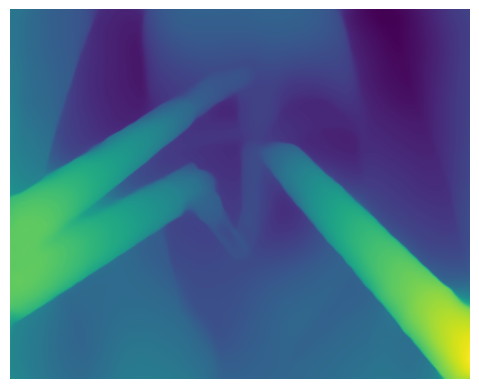

In [2]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn

from peft import TaskType
from peft import LoraModel, LoraConfig
from peft import LoraConfig, get_peft_model, PeftModel


class DepthAnythingDepthEstimationHead(nn.Module):

    def __init__(self, model_head):
        super().__init__()

        self.conv1 = model_head.conv1
        self.conv2 = model_head.conv2
        self.activation1 = nn.ReLU()
        self.conv3 = model_head.conv3
        self.activation2 = nn.ReLU()

    def forward(self, hidden_states, height, width):

        predicted_depth = self.conv1(hidden_states)
        predicted_depth = nn.functional.interpolate(
            predicted_depth,
            (int(height), int(width)),
            mode="bilinear",
            align_corners=True,
        )
        print('head predicted_depth:', predicted_depth.shape)
        predicted_depth = self.conv2(predicted_depth)
        predicted_depth = self.activation1(predicted_depth)
        predicted_depth = self.conv3(predicted_depth)
        predicted_depth = self.activation2(predicted_depth)
        predicted_depth = predicted_depth.squeeze(dim=1)  # shape (batch_size, height, width)

        return predicted_depth


class Customised_DAM(nn.Module):
    def __init__(self, dora_config=None):
        super(Customised_DAM, self).__init__()
        model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
        model = get_peft_model(model, dora_config)
        self.config = model.config
        self.backbone = model.backbone

        self.neck = model.neck
        model_head = model.head
        self.head = DepthAnythingDepthEstimationHead(model_head)
        model.post_init()


    def forward(self, pixel_values):

        outputs = self.backbone(
            pixel_values, output_hidden_states=None, output_attentions=None
        ) # pixel_values:[3, 256, 320] , output:4, [1, 397, 384]
        hidden_states = outputs.feature_maps
        print(hidden_states[0].shape)
        _, _, height, width = pixel_values.shape
        patch_size = self.config.patch_size
        patch_height = height // patch_size
        patch_width = width // patch_size

        # print('h,w, p, ph, pw', height, width, patch_size, patch_height, patch_width) #h,w, p, ph, pw 256 320 14 18 22
        hidden_states = self.neck(hidden_states, patch_height, patch_width)

        #[1, 64, 18, 22], [1, 64, 36, 44], [1, 64, 72, 88], [1, 64, 144, 176]
        # print('hidden_states2', len(hidden_states), hidden_states[0].shape, hidden_states[1].shape, hidden_states[2].shape, hidden_states[3].shape)
        predicted_depth = self.head(hidden_states[3], height, width)
        # outputs = {}
        # outputs[("disp", 0)] = self.head(hidden_states[3], height, width)
        # outputs[("disp", 1)] = self.head(hidden_states[3], height/2, width/2)
        # outputs[("disp", 2)] = self.head(hidden_states[3], height/4, width/4)
        # outputs[("disp", 3)] = self.head(hidden_states[3], height/8, width/8)
        # print(outputs[("disp", 0)].shape, outputs[("disp", 1)].shape,outputs[("disp", 2)].shape,outputs[("disp", 3)].shape,)
        # return outputs[("disp", 0)]
        return predicted_depth


# Configure DoRA
dora_config = LoraConfig(
    # task_type=TaskType.CAUSAL_LM,  # GPT-2 is a causal LM
    r=8,  # Rank for adaptation
    lora_alpha=16,  # Scaling factor
    lora_dropout=0.1,  # Regularization
    target_modules=["query", "value"],  # Apply to DA
    use_dora=True  # ✅ Enables DoRA adaptation instead of standard LoRA
)


url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")

print('raw input', image.size[::-1])
inputs = image_processor(images=image, return_tensors="pt")
model_dare = Customised_DAM(dora_config=dora_config)
with torch.no_grad():
    predicted_depth = model_dare(**inputs)

print('raw input', image.size[::-1],'inputs',inputs['pixel_values'].shape, 'predicted_depth', predicted_depth.shape)

# visualize the prediction
output = predicted_depth.squeeze().cpu().numpy()

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
plt.figure(122),plt.axis('OFF'),plt.imshow(depth);